In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Load datasets
data_dir = '/kaggle/input/dogs-skin-diseases-image-dataset/'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid', 'test']
}

In [5]:
# Create dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
    for x in ['train', 'valid', 'test']
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [ ]:
# Print class names and count for use in the Flask app
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

In [7]:
# Load and modify ResNet model
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                
        print('='*10)
    
    return model

In [10]:
# Test function with metrics
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names)
    
    # Calculate per-class metrics
    tn = cm.sum(axis=1) - cm.diagonal()
    fp = cm.sum(axis=0) - cm.diagonal()
    tp = cm.diagonal()
    fn = cm.sum() - (tp + fp + tn)
    
    accuracy = (tp.sum()) / (tp.sum() + fp.sum() + fn.sum() + tn.sum())
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    # Print results
    print('Overall Accuracy:', accuracy)
    print('Classification Report:')
    print(report)
    
    print('Per-class metrics:')
    for i, class_name in enumerate(class_names):
        print(f'{class_name}:')
        print(f'Precision: {precision[i]:.4f}')
        print(f'Recall: {recall[i]:.4f}')
        print(f'Specificity: {specificity[i]:.4f}')
        print(f'F1-score: {f1[i]:.4f}')
        print('='*10)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Training model...
Epoch 0/19
train Loss: 1.2251 Acc: 0.5791
valid Loss: 0.7475 Acc: 0.7360
Epoch 1/19
train Loss: 0.8004 Acc: 0.7055
valid Loss: 0.5610 Acc: 0.7988
Epoch 2/19
train Loss: 0.6693 Acc: 0.7574
valid Loss: 0.4823 Acc: 0.8442
Epoch 3/19
train Loss: 0.5838 Acc: 0.7862
valid Loss: 0.4357 Acc: 0.8453
Epoch 4/19
train Loss: 0.5096 Acc: 0.8177
valid Loss: 0.3901 Acc: 0.8779
Epoch 5/19
train Loss: 0.4830 Acc: 0.8236
valid Loss: 0.3455 Acc: 0.8884
Epoch 6/19
train Loss: 0.4273 Acc: 0.8458
valid Loss: 0.3290 Acc: 0.8977
Epoch 7/19
train Loss: 0.3864 Acc: 0.8693
valid Loss: 0.3095 Acc: 0.9047
Epoch 8/19
train Loss: 0.3421 Acc: 0.8875
valid Loss: 0.2979 Acc: 0.9105
Epoch 9/19
train Loss: 0.3167 Acc: 0.8875
valid Loss: 0.2902 Acc: 0.9198
Epoch 10/19
train Loss: 0.2993 Acc: 0.8981
valid Loss: 0.2832 Acc: 0.9198
Epoch 11/19
train Loss: 0.3048 Acc: 0.8974
valid Loss: 0.2709 Acc: 0.9151
Epoch 12/19
train Loss: 0.2909 Acc: 0.9047
valid Loss: 0.2860 Acc: 0.9163
Epoch 13/19
train Loss: 0.2660

<ipython-input-11-eb3406e6eca5>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Overall Accuracy: 0.1585835257890685
Classification Report:
                   precision    recall  f1-score   support

       Dermatitis       0.95      0.91      0.93        66
Fungal_infections       0.90      0.87      0.89        54
          Healthy       0.92      0.96      0.94        69
 Hypersensitivity       0.90      0.93      0.92        29
      demodicosis       0.99      1.00      1.00       100
         ringworm       0.97      0.97      0.97       115

         accuracy                           0.95       433
        macro avg       0.94      0.94      0.94       433
     weighted avg       0.95      0.95      0.95       433

Per-class metrics:
Dermatitis:
Precision: 0.9524
Recall: 0.1415
Specificity: 0.6667
F1-score: 0.2464
Fungal_infections:
Precision: 0.9038
Recall: 0.1116
Specificity: 0.5833
F1-score: 0.1987
Healthy:
Precision: 0.9167
Recall: 0.1557
Specificity: 0.3333
F1-score: 0.2661
Hypersensitivity:
Precision: 0.9000
Recall: 0.0631
Specificity: 0.4000
F1-scor

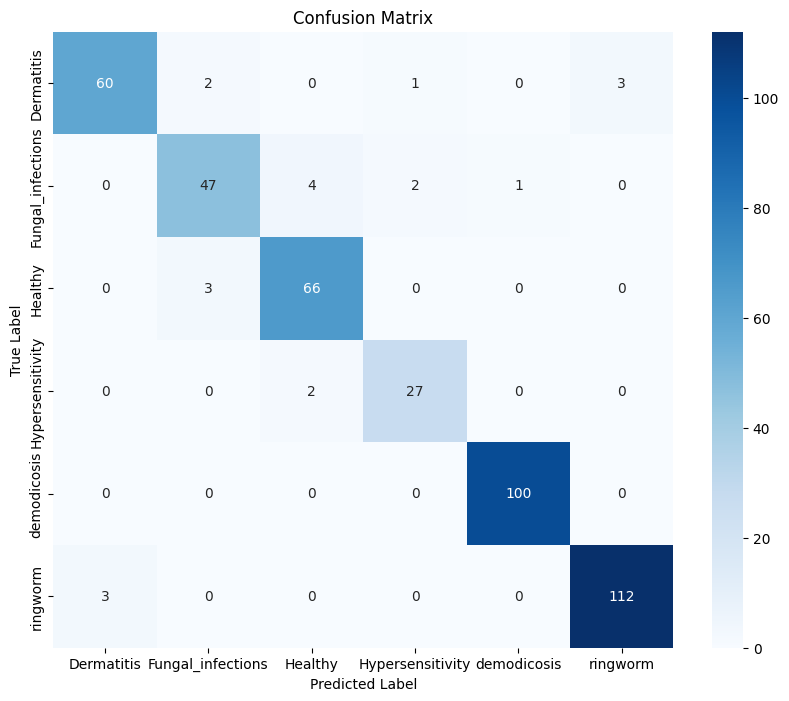

In [11]:
# Main execution
if __name__ == '__main__':
    # Train the model
    print("Training model...")
    model = train_model(model, criterion, optimizer, num_epochs=20)
    
    # Load best model weights
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Evaluate on test set
    print("Evaluating on test set...")
    evaluate_model(model)